In [1]:
import os
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import open3d as o3d
import open3d.t.pipelines.registration as treg
from tqdm.notebook import tqdm

from scipy.spatial.transform import Rotation
import time
import copy

import torch
import MinkowskiEngine as ME

%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def visualize_pcd(ref_cloud, color=False):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(ref_cloud[:, 3:] / 255)

    o3d.visualization.draw_plotly([pcd], width=800, height=600)


def draw_registration_result(source, target, transformation, title=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    source_temp.transform(transformation)

    if title is not None:
        print(title)

    o3d.visualization.draw_plotly([source_temp, target_temp])


def compare_grids(grid1, grid2, label1='Current grid', label2='Reference grid'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = mpt.colors.ListedColormap(['white', 'gray', 'black'])

    axs[0].imshow(grid1, cmap=cmap)
    axs[0].set_title(label1)
    axs[0].grid(True, alpha=0.5, linestyle='-')

    axs[1].imshow(grid2, cmap=cmap)
    axs[1].set_title(label2)
    axs[1].grid(True, alpha=0.5, linestyle='-')

    fig.tight_layout()
    fig.show()


def visualize_iou(aligned_grid):
    plt.imshow(aligned_grid)
    plt.axis(False)
    plt.grid(True, alpha=0.5, linestyle='-')

    plt.show()


def make_pcd_from_array(array):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(array)

    return pcd

In [3]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    #gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

def get_rel_pose(x1, y1, theta1, x2, y2, theta2):
    return [x1 - x2, y1 - y2, theta1 - theta2]

In [4]:
from dataclasses import dataclass, asdict

@dataclass
class RegistrationResult:
    method_name: str
    data_cloud: str
    candidate_idx: int
    iou: float
    dist: float
    fitness: float
    transform: list
    error: list

In [5]:
import json

def save_results(filename, arr):
    data_to_save = [asdict(el) for el in arr]
    with open(f'{filename}.json', 'w') as file:
        json.dump(data_to_save, file)


def load_results(filename):
    with open(f'{filename}.json', 'r') as file:
        return [RegistrationResult(**x) for x in json.load(file)]

In [104]:
def calc_precision_recall_f1(results, threshold):
    precision = np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                                for el in results]) / \
                        np.sum([(el.fitness > threshold) for el in results])
    recall = np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                                for el in results]) / \
                        np.sum([el.iou > 0.5 for el in results])
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1

def print_precision_recall(results, method, threshold):
    precision, recall, f1 = calc_precision_recall_f1(results, threshold)

    print(f'Precision {method}: {precision:.3f}')
    print(f'Recall {method}: {recall:.3f}', )
    print(F'F1 score {method}: {f1:.3f}')

In [77]:
results_fastmac = load_results('fastmac_res_15k_voxel_01')
results_icp = load_results('icp_res')

In [78]:
results_fastmac.sort(key=lambda x: (x.data_cloud, x.candidate_idx))
results_icp.sort(key=lambda x: (x.data_cloud, x.candidate_idx))

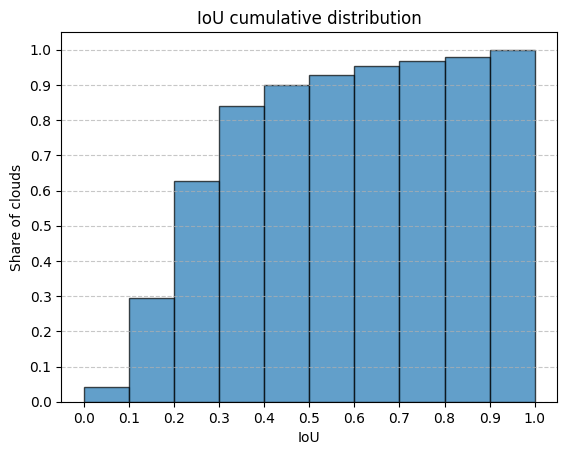

In [102]:
plt.hist([el.iou for el in results_fastmac], bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7, cumulative=True, density=True)

plt.xlabel('IoU')
plt.ylabel('Share of clouds')
plt.title('IoU cumulative distribution')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

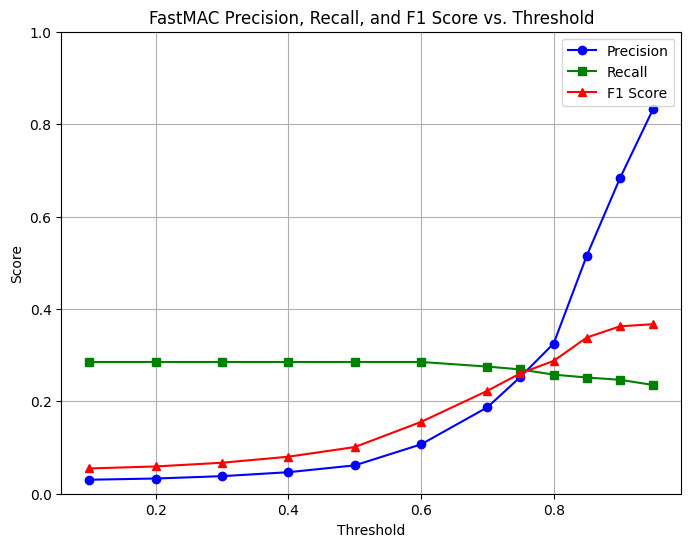

In [105]:
precisions = []
recalls = []
f1s = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


for threshold in thresholds:
    precision, recall, f1 = calc_precision_recall_f1(results_fastmac, threshold)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision', color='blue')
plt.plot(thresholds, recalls, marker='s', label='Recall', color='green')
plt.plot(thresholds, f1s, marker='^', label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FastMAC Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [106]:
print_precision_recall(results_fastmac, 'FastMAC', 0.95)

Precision FastMAC: 0.833
Recall FastMAC: 0.235
F1 score FastMAC: 0.367


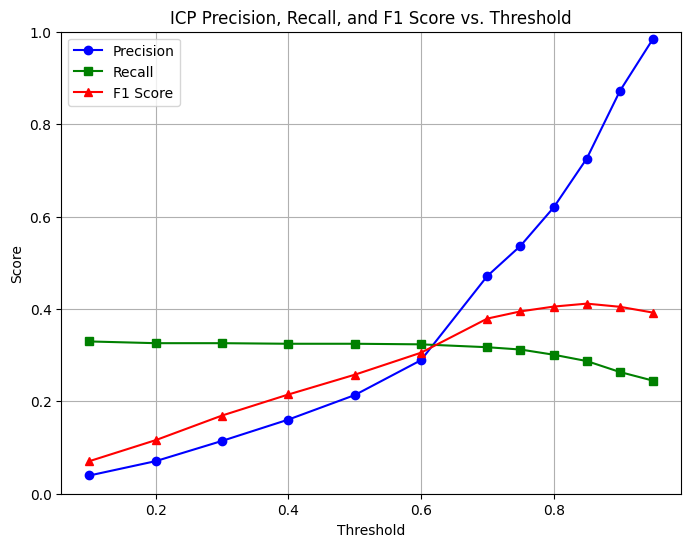

In [107]:
precisions = []
recalls = []
f1s = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    precision, recall, f1 = calc_precision_recall_f1(results_icp, threshold)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision', color='blue')
plt.plot(thresholds, recalls, marker='s', label='Recall', color='green')
plt.plot(thresholds, f1s, marker='^', label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('ICP Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [109]:
print_precision_recall(results_icp, 'ICP', 0.7)

Precision ICP: 0.471
Recall ICP: 0.317
F1 score ICP: 0.379


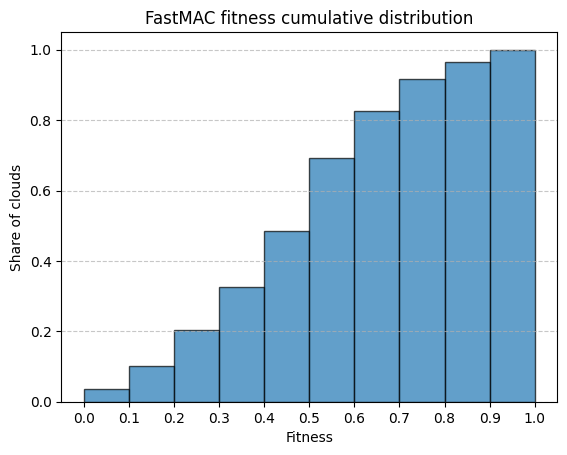

In [53]:
plt.hist([el.fitness for el in results_fastmac], bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7, cumulative=True, density=True)

plt.xlabel('Fitness')
plt.ylabel('Share of clouds')
plt.title('FastMAC fitness cumulative distribution')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

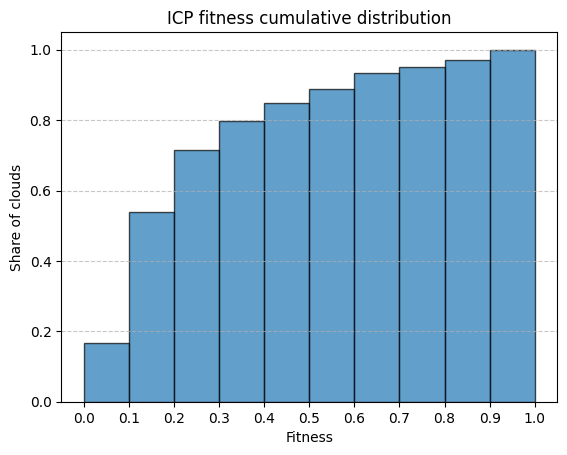

In [54]:
plt.hist([el.fitness for el in results_icp], bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7, cumulative=True, density=True)

plt.xlabel('Fitness')
plt.ylabel('Share of clouds')
plt.title('ICP fitness cumulative distribution')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

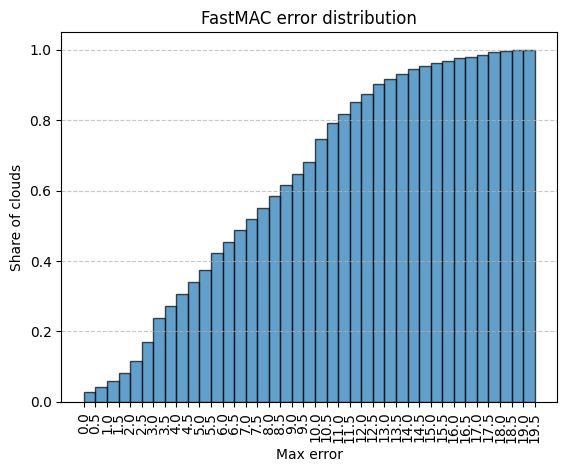

In [88]:
plt.hist([max(el.error) for el in results_fastmac], bins=np.arange(0, 20, 0.5), edgecolor='black', alpha=0.7, density=True, cumulative=True)

plt.xlabel('Max error')
plt.ylabel('Share of clouds')
plt.title('FastMAC error distribution')
plt.xticks(np.arange(0, 20, 0.5), rotation=90)
# plt.ylim((0, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

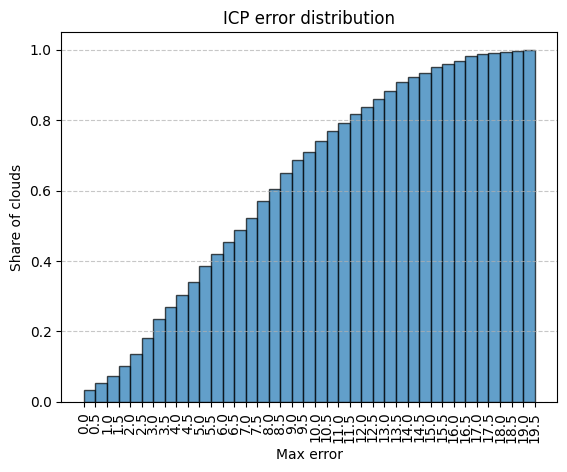

In [89]:
plt.hist([max(el.error) for el in results_icp], bins=np.arange(0, 20, 0.5), edgecolor='black', alpha=0.7, density=True, cumulative=True)

plt.xlabel('Max error')
plt.ylabel('Share of clouds')
plt.title('ICP error distribution')
plt.xticks(np.arange(0, 20, 0.5), rotation=90)
# plt.ylim((0, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [72]:
np.sum([(el.fitness > threshold) * (max(el.error[:-1]) < 0.5) for el in results_icp]), np.sum([(el.fitness > threshold) for el in results_icp])

(197, 199)

In [35]:
np.sum([(el.fitness > threshold) * (max(el.error[:-1]) < 0.5) for el in results_fastmac]), np.sum([(el.fitness > threshold) for el in results_fastmac])

(251, 1733)

In [38]:
np.mean([max(el.error[:-1]) for el in results_icp]), np.median([max(el.error[:-1]) for el in results_icp])

(7.561715452051733, 7.274358815247594)

In [39]:
np.mean([max(el.error[:-1]) for el in results_fastmac]), np.median([max(el.error[:-1]) for el in results_fastmac])

(7.578989988756997, 7.440232650860338)

In [45]:
np.sum([(el.fitness > threshold) * (max(el.error[:-1]) < 0.5) for el in results_icp]), np.sum([(el.fitness > threshold) for el in results_icp])

(315, 539)

In [52]:
np.sum([(el.fitness > threshold) * (max(el.error[:-1]) < 0.5) for el in results_fastmac]), np.sum([(el.fitness > threshold) for el in results_fastmac])

(237, 521)

In [87]:
print('Number of correct ICP matches with IoU > 0.5:', np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                              for el in results_icp if el.iou > 0.5]))

Number of correct ICP matches with IoU > 0.5: 235


In [88]:
print('Number of correct FastMac matches with IoU > 0.5:', np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                              for el in results_fastmac if el.iou > 0.5]))

Number of correct FastMac matches with IoU > 0.5: 234


In [36]:
# FastMac выбивает большой fitness примерно также как и ICP, но 
# Precision такой низкий, потому что много облаков точек имеет fitness > 0.7, 1242 против 539 у ICP. При этом количество облаков, на которых error меньше 0.5 практически столько же 220 против 254
# Если брать не обратную матрицу, то результат ещё ближе - 244 облака, а fitness > 0.7 имеет 1733 облака

In [13]:
# Change to the actual path to dataset
dataset_dir = '../data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

In [21]:
results_fastmac.sort(key=lambda x: (x.data_cloud, x.candidate_idx))
results_icp.sort(key=lambda x: (x.data_cloud, x.candidate_idx))

In [90]:
i_fastmac = 0
i_icp = 0

icp_positive_mac_positive = 0

icp_positive_mac_negative = 0

icp_negative_mac_positive = 0

counter = 0

while i_fastmac < len(results_fastmac) and i_icp < len(results_icp):
    res_fastmac = results_fastmac[i_fastmac]
    res_icp = results_icp[i_icp]

    if res_fastmac.data_cloud != res_icp.data_cloud:
        print('damn!!!!!...')
        i_icp += 1
        continue

    if res_fastmac.candidate_idx != res_icp.candidate_idx:
        print('damn...')

        i_fastmac += 1
        i_icp += 1
        continue

    # print(res_fastmac.candidate_idx, res_fastmac_inv.candidate_idx, res_icp.candidate_idx)

    assert (res_fastmac.data_cloud == res_icp.data_cloud and res_fastmac.candidate_idx == res_icp.candidate_idx)

    positive_icp = (res_icp.fitness > 0.95) and (max(res_icp.error) < 0.5)
    positive_fastmac = (res_fastmac.fitness > 0.95) and (max(res_fastmac.error) < 0.5)

    if positive_icp:
        if positive_fastmac:
            icp_positive_mac_positive += 1
        else:
            icp_positive_mac_negative += 1

    else:
        if positive_fastmac:
            icp_negative_mac_positive += 1


    i_fastmac += 1
    i_icp += 1
    counter += 1


damn...
damn...
damn...
damn!!!!!...
damn...
damn...
damn...
damn...
damn!!!!!...
damn...
damn...
damn...
damn...
damn!!!!!...
damn...
damn...
damn...
damn...
damn!!!!!...


In [91]:
counter

8006

In [92]:
print(f'ICP positive; FastMAC positive: {icp_positive_mac_positive}')
print(f'ICP positive; FastMAC negative: {icp_positive_mac_negative}')
print(f'ICP negative; FastMAC positve: {icp_negative_mac_positive}')
print(f'ICP negative; FastMAC negative: {counter - icp_positive_mac_positive - icp_positive_mac_negative - icp_negative_mac_positive}')

ICP positive; FastMAC positive: 177
ICP positive; FastMAC negative: 15
ICP negative; FastMAC positve: 12
ICP negative; FastMAC negative: 7802


In [93]:
i_fastmac = 0
i_icp = 0

unmatched = []

while i_fastmac < len(results_fastmac) and i_icp < len(results_icp):
    res_fastmac = results_fastmac[i_fastmac]
    res_icp = results_icp[i_icp]

    if res_fastmac.data_cloud != res_icp.data_cloud:
        print('damn!!!!!...')
        i_icp += 1
        continue

    if res_fastmac.candidate_idx != res_icp.candidate_idx:
        print('damn...')

        i_fastmac += 1
        i_icp += 1
        continue

    assert (res_fastmac.data_cloud == res_icp.data_cloud and res_fastmac.candidate_idx == res_icp.candidate_idx)

    positive_icp = (res_icp.fitness > 0.95) and (max(res_icp.error) < 0.5)
    positive_fastmac = (res_fastmac.fitness > 0.95) and (max(res_fastmac.error) < 0.5)

    if positive_icp and not positive_fastmac:
            unmatched.append([res_icp, res_fastmac])

    i_fastmac += 1
    i_icp += 1

damn...
damn...
damn...
damn!!!!!...
damn...
damn...
damn...
damn...
damn!!!!!...
damn...
damn...
damn...
damn...
damn!!!!!...
damn...
damn...
damn...
damn...
damn!!!!!...


In [94]:
len(unmatched)

15

In [96]:
fitness_error = 0
dist_error = 0

for _, mac_el in unmatched:
    if mac_el.fitness <= 0.95:
        fitness_error += 1
    if max(mac_el.error) > 0.5:
        dist_error += 1

fitness_error, dist_error

(15, 8)

(array([1., 0., 0., 0., 0., 0., 1., 4., 4., 5.]),
 array([0.59339787, 0.6281549 , 0.66291192, 0.69766895, 0.73242597,
        0.767183  , 0.80194002, 0.83669705, 0.87145407, 0.9062111 ,
        0.94096812]),
 <BarContainer object of 10 artists>)

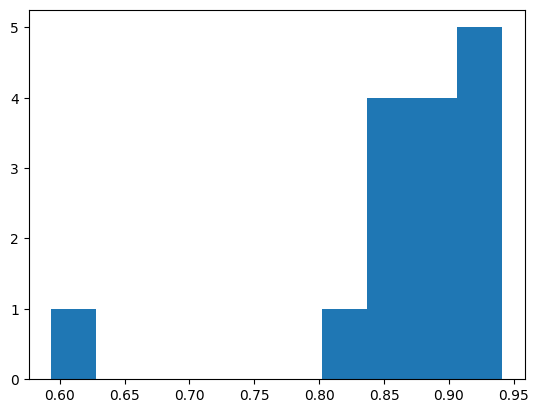

In [97]:
plt.hist([el.iou for _, el in unmatched])

In [ ]:
# results_icp_inv = []

# for res in tqdm(results_icp):
#     test_dir = os.path.join(pr_data_dir, res.data_cloud)

#     try:
#         transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
#     except FileNotFoundError:
#         continue

#     if transforms_.size == 0:
#         continue
#     if transforms_.ndim == 1:
#         transforms_ = transforms_[np.newaxis, :]

#     cand_clouds = {}
#     cand_poses = {}

#     # Reference cloud (from robot)
#     with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
#         ref_cloud = CloudFile['arr_0']

#     ref_cloud = ref_cloud[:, :3]
#     ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

#     if transforms_.size == 0:
#         pass

#     for idx in transforms_[:, 0]:
#         cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
#         pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
#         cand_clouds[int(idx)] = cloud
#         cand_poses[int(idx)] = pose_stamped[1:]

#     gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

#     i = res.candidate_idx

#     idx = transforms_[i, 0]
#     gt_pose = cand_poses[int(idx)]
#     pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

#     # Candidate cloud (from graph of locations)
#     cloud = cand_clouds[idx][:, :3]
#     cloud = cloud[cloud == cloud].reshape((-1, 3))

#     pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

#     voxel_size = 0.2

#     transformation_matrix = np.linalg.inv(np.array(res.transform))
#     er = transformation_error(pose_shift, transformation_matrix)
#     evaluation = o3d.pipelines.registration.evaluate_registration(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), 0.9, transformation_matrix)

#     results_icp_inv.append(
#         RegistrationResult(
#             method_name='icp_inv',
#             data_cloud=res.data_cloud,
#             candidate_idx=i,
#             iou=float(res.iou),
#             dist=float(res.dist),
#             fitness=float(evaluation.fitness),
#             transform=list([list(el) for el in transformation_matrix.astype(float)]),
#             error=list(er)
#             )
#     )

  0%|          | 0/8025 [00:00<?, ?it/s]